In [25]:
from crpropa import *
from crpropa import Module
from Monopole import Monopole

In [26]:
from numpy import sqrt

#From Gibbs, Philip. "The Relativistic Rocket"
#https://math.ucr.edu/home/baez/physics/Relativity/SR/Rocket/rocket.html
def analytical_position(max_time, number_steps, g, B, m, t):
    z = c_light**2 * m / g / B * (sqrt(1 + (g * B * t / m / c_light)**2) - 1)
    return z / pc

def analytical_velocity(max_time, number_steps, g, B, m, t):
    a = g * B / m
    vz = a * t / sqrt(1 + (a * t / c_light)**2)
    return vz

In [27]:
class MyTrajectoryOutput(Module):
    """
    Custom trajectory output: vx, vy, vz
    where i is a running cosmic ray number
    and x,y,z are the Galactocentric coordinates in [kpc].
    """
    def __init__(self, fname):
        Module.__init__(self)
        self.fout = open(fname, 'w')
        self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(1, 0, 0, 0))
    def process(self, c):
        i = 1
        c = Monopole.MCandidate.convertToMCandidate(c)
        v = c.Mcurrent.getVelocity()
        x = v.x
        y = v.y
        z = v.z
        self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(i, x, y, z))
    def close(self):
        self.fout.close()

In [28]:
import time as Time

B = 10*nG
direction_B = Vector3d(0, 0, 1)

m = 100*gigaelectronvolt/c_squared 
g = 1*Monopole.gD

const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)


### Running the simulation with either CK or BP
def run_simulation(module, max_time, number_steps, g, m):
    direction = Vector3d(0, 0, 1)
    position = Vector3d(5, 5, 5)
    energy = 0 

    c = Monopole.MCandidate(4110000, energy, position, direction, m, g)
    print(c.Mcurrent.getDescription())
    
    steplength = max_time/number_steps * c_light
    sim = ModuleList()
    if module == 'CK':
        sim.add(Monopole.MonopolePropagationCK(reg_field,1e-4,steplength, steplength))
        trajectory_output = TextOutput('trajectory_CK.txt', Output.Trajectory3D)
        velocity_output = MyTrajectoryOutput('velocity_CK.txt')
    elif module == 'BP':
        sim.add(Monopole.MonopolePropagationBP(reg_field, steplength))
        trajectory_output = TextOutput('trajectory_BP.txt', Output.Trajectory3D)
        velocity_output = MyTrajectoryOutput('velocity_BP.txt')
    else:
        print('no module found. Use either BP or CK.')
        return

    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_time*c_light))
    # the output information will be saved in pc instead of the default which is Mpc
    trajectory_output.setLengthScale(pc)
    # each particle position will be saved in the above specified text field.
    sim.add(trajectory_output)
    sim.add(velocity_output)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    trajectory_output.close()
    velocity_output.close() # flush particles to ouput file
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.1)


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots_para(ax1, ax2, data, z_ana, t, module, color):
    #numerical
    ax1.scatter(t[::200],data[::200], color = color, label=module, zorder=5, s=10)
    
    #analytical
    ax1.plot(t,z_ana, color = 'k', label='analytical', ls='-')
    ax1.legend()
    
    # compare with analytical solution
    comp = 100*abs(data-z_ana)/z_ana
    ax2.scatter(t, comp,s=1, color = color, label=module)
    ax2.legend(markerscale=5)
    ax2.set_yscale('log')
    
def plot_figure_para(max_time, number_steps, g, B, m):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(12,12))

    # calculate the time stamps similar to that used in the numerical simulation
    data1 = load_trajectory('trajectory_BP.txt')
    data2 = load_trajectory('trajectory_CK.txt')
    v3 = load_velocity('velocity_BP.txt')
    v4 = load_velocity('velocity_CK.txt')
    
    t = np.linspace(0, max_time, len(data2))
    z_ana = analytical_position(max_time, number_steps, g, B, m, t)
    vz_ana = analytical_velocity(max_time, number_steps, g, B, m, t)

    plot_subplots_para(ax1, ax2, data1.Z, z_ana, t, 'BP', 'brown')
    plot_subplots_para(ax3, ax4, data2.Z, z_ana, t, 'CK', 'dodgerblue')
    plot_subplots_para(ax5, ax6, v3, vz_ana, t, 'BP', 'brown')
    plot_subplots_para(ax7, ax8, v4, vz_ana, t, 'CK', 'dodgerblue')
    
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$z$ [pc]')
    ax1.set_title('position vs. time', fontsize=18)
    
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('$error$ [%]')
    ax2.set_title('percentage error vs. time', fontsize=18)
    
    ax3.set_xlabel('$t$ [s]')
    ax3.set_ylabel('$z$ [pc]')
    ax4.set_xlabel('t [s]')
    ax4.set_ylabel('error [%]')
    
    ax5.set_xlabel('$t$ [s]')
    ax5.set_ylabel('$vz$ [m/s]')
    ax5.set_title('velocity vs. time', fontsize=18)
    
    ax6.set_xlabel('t [s]')
    ax6.set_ylabel('$error$ [%]')
    ax6.set_title('percentage error vs. time', fontsize=18)
    
    ax7.set_xlabel('$t$ [s]')
    ax7.set_ylabel('$vz$ [m/s]')
    ax8.set_xlabel('t [s]')
    ax8.set_ylabel('$error$ [%]')
    
    fig.tight_layout()
    plt.show()

In [30]:
import pandas as pd

def load_trajectory(text):
    data = pd.read_csv(text,
                 names=['D','ID','E','X','Y','Z','Px','Py','Pz'], delimiter='\t', comment='#',
                 usecols=["D", "X", "Y", "Z","Px","Py","Pz"])
    top = pd.DataFrame([{"D": 0, "X":0, "Y":0, "Z":0, "Py":0, "Pz":0}])
    data = pd.concat([top, data]).reset_index(drop = True)
    data.drop(data.tail(1).index,inplace=True) # drop last n rows
    return data

def load_velocity(text):
    I, X,Y,Z = np.genfromtxt(text, unpack=True, skip_footer=1)
    return Z



Particle 4110000, E = 0 EeV, x = 1.62039e-22 1.62039e-22 1.62039e-22 Mpc, p = 0 0 1 (direction), q = 0 C, m = 100 GeV/c^2, gD = 1 gD
Simulation time with module CK is 0.1497194766998291s.
Particle 4110000, E = 0 EeV, x = 1.62039e-22 1.62039e-22 1.62039e-22 Mpc, p = 0 0 1 (direction), q = 0 C, m = 100 GeV/c^2, gD = 1 gD
Simulation time with module BP is 0.12418937683105469s.


/tmp/ipykernel_2785/2244694914.py:13: RuntimeWarning: invalid value encountered in divide
  comp = 100*abs(data-z_ana)/z_ana


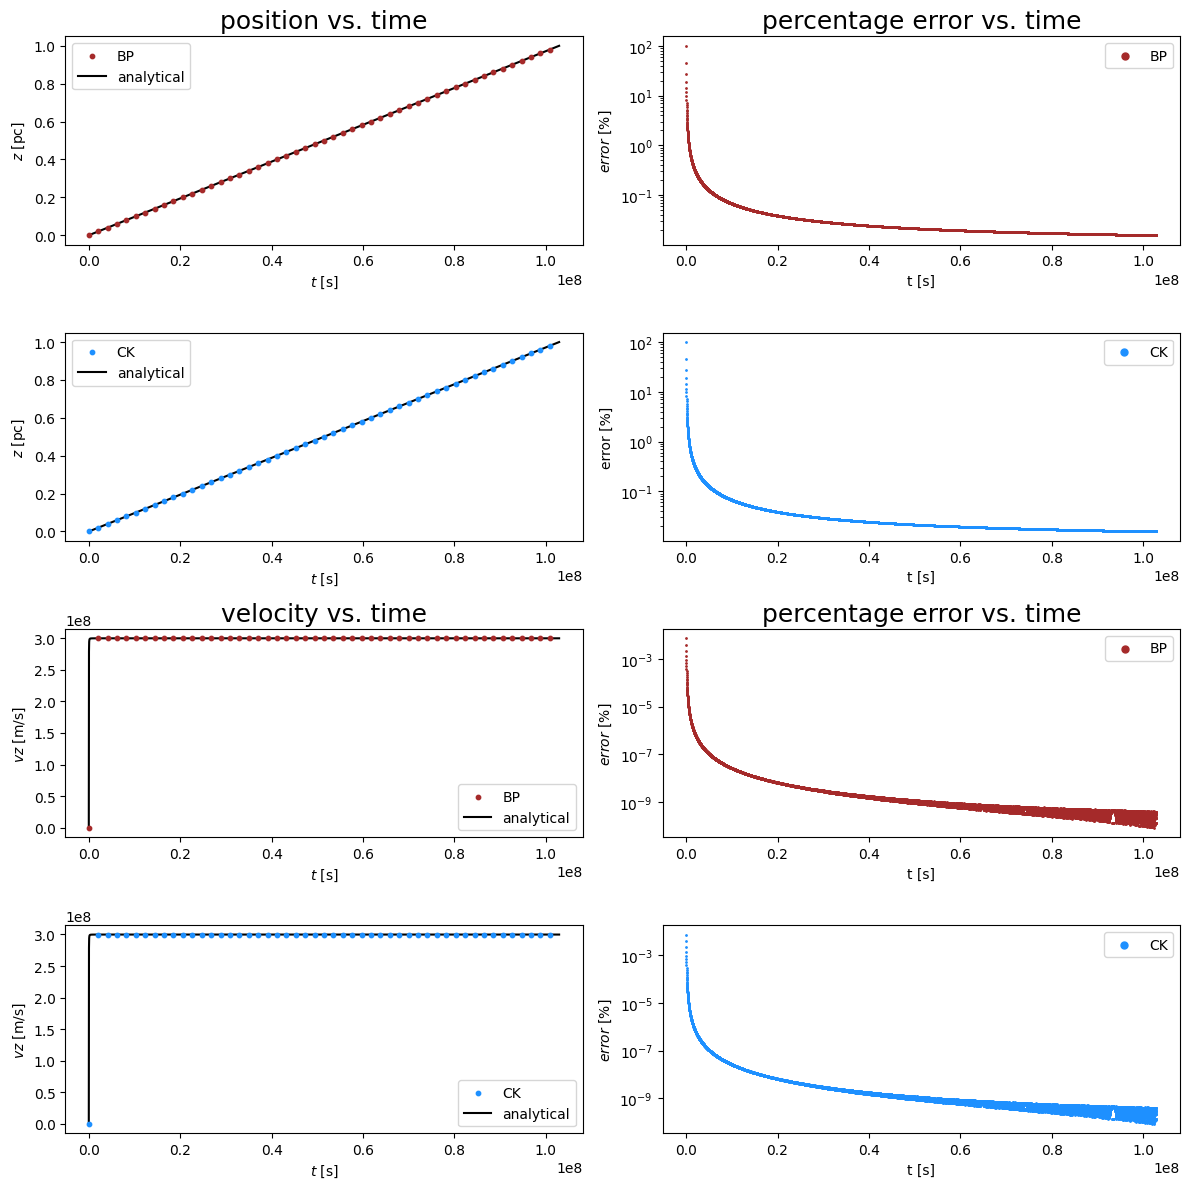

In [31]:
max_dist = 1*pc
number_steps = 10000
max_time = max_dist/c_light
run_simulation('CK', max_time, number_steps, g, m)
run_simulation('BP', max_time, number_steps, g, m)
plot_figure_para(max_time, number_steps, g, B, m)

In [36]:
print( 1 * Monopole.gD * 40 * kpc * 400 * nG / EeV)

1014.1354109672297
